## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
!"C:\Program Files\NVIDIA Corporation\NVSMI\nvidia-smi.exe"

Mon Apr 01 00:34:18 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 399.24                 Driver Version: 399.24                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 970    WDDM  | 00000000:01:00.0  On |                  N/A |
| 34%   30C    P8    18W / 250W |    278MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
import keras
from keras.regularizers import l1, l2, l1_l2
import tensorflow as tf

from numba import cuda
cuda.select_device(0)
cuda.close()

import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [6]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=y_train.shape[-1], n_layers=4, num_neurons=[512, 256, 128, 64]):

    input_layer = keras.layers.Input(input_shape)

    for i, n_units in enumerate(num_neurons[:n_layers]):
        if i == 0:
            x = BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units,activation='relu',name='hidden_layers'+str(i+1))(x)

        else:
            x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units,activation='relu',name='hidden_layers'+str(i+1))(x)      

    output_layer = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer]) 

    return model

In [8]:
## 超參數設定

LEARNING_RATE = 1e-3
OPTIMIZER = 'Adam'
EPOCHS = 50
BATCH_SIZE = [16, 32 , 128, 256]

In [13]:
def model_fitting( learning_rate=LEARNING_RATE, optimizer=OPTIMIZER, 
                  epochs=EPOCHS, batch_size=BATCH_SIZE, input_shape=x_train.shape[1:] ):

    keras.backend.clear_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)

    
    model = build_mlp( input_shape=input_shape )
    model.summary()

    selector = {'SGD': keras.optimizers.SGD(lr=learning_rate, momentum=0.95, nesterov=True),
                'RMSprop': keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None),
                'AdaGrad': keras.optimizers.Adagrad(lr=learning_rate, epsilon=None), 
                'Adam': keras.optimizers.Adam(lr=learning_rate, epsilon=None, amsgrad=True)}

    optimizer = selector.get(optimizer)

    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    history = model.fit(x_train, y_train, epochs=epochs, 
                        batch_size=batch_size,validation_data=(x_test, y_test), 
                        shuffle=False, verbose=2)

    sess.close()

    return history

In [14]:
results = {}

for batch_size in BATCH_SIZE:
    
    outcome = model_fitting( batch_size = batch_size )
    
    name_tag = f'Batch Size = {batch_size}'
    results[name_tag] = {'train_loss': outcome.history['loss'],
                         'valid_loss': outcome.history['val_loss'],
                         'train_acc': outcome.history['acc'],
                         'valid_acc': outcome.history['val_acc']}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layers1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layers2 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layers3 (Dense)       (None, 128)               32896     
__________

Epoch 8/50
 - 16s - loss: 0.8703 - acc: 0.6939 - val_loss: 1.5214 - val_acc: 0.5227
Epoch 9/50
 - 16s - loss: 0.7947 - acc: 0.7189 - val_loss: 1.5926 - val_acc: 0.5160
Epoch 10/50
 - 16s - loss: 0.7290 - acc: 0.7414 - val_loss: 1.6919 - val_acc: 0.5134
Epoch 11/50
 - 17s - loss: 0.6473 - acc: 0.7692 - val_loss: 1.7798 - val_acc: 0.5085
Epoch 12/50
 - 16s - loss: 0.6021 - acc: 0.7830 - val_loss: 1.8675 - val_acc: 0.5139
Epoch 13/50
 - 17s - loss: 0.5404 - acc: 0.8056 - val_loss: 1.9348 - val_acc: 0.5115
Epoch 14/50
 - 17s - loss: 0.4872 - acc: 0.8272 - val_loss: 2.0357 - val_acc: 0.5163
Epoch 15/50
 - 16s - loss: 0.4418 - acc: 0.8413 - val_loss: 2.1088 - val_acc: 0.5094
Epoch 16/50
 - 16s - loss: 0.4173 - acc: 0.8497 - val_loss: 2.1701 - val_acc: 0.5120
Epoch 17/50
 - 16s - loss: 0.3705 - acc: 0.8669 - val_loss: 2.2713 - val_acc: 0.5167
Epoch 18/50
 - 16s - loss: 0.3289 - acc: 0.8810 - val_loss: 2.3790 - val_acc: 0.5115
Epoch 19/50
 - 16s - loss: 0.3023 - acc: 0.8905 - val_loss: 2.4958 

Epoch 35/50
 - 6s - loss: 0.0829 - acc: 0.9711 - val_loss: 3.3894 - val_acc: 0.5254
Epoch 36/50
 - 6s - loss: 0.0738 - acc: 0.9748 - val_loss: 3.4371 - val_acc: 0.5291
Epoch 37/50
 - 6s - loss: 0.0727 - acc: 0.9750 - val_loss: 3.3960 - val_acc: 0.5333
Epoch 38/50
 - 6s - loss: 0.0675 - acc: 0.9769 - val_loss: 3.4797 - val_acc: 0.5246
Epoch 39/50
 - 6s - loss: 0.0621 - acc: 0.9786 - val_loss: 3.5125 - val_acc: 0.5288
Epoch 40/50
 - 6s - loss: 0.0547 - acc: 0.9815 - val_loss: 3.5631 - val_acc: 0.5282
Epoch 41/50
 - 6s - loss: 0.0495 - acc: 0.9837 - val_loss: 3.4910 - val_acc: 0.5320
Epoch 42/50
 - 6s - loss: 0.0443 - acc: 0.9857 - val_loss: 3.5519 - val_acc: 0.5360
Epoch 43/50
 - 6s - loss: 0.0402 - acc: 0.9871 - val_loss: 3.5915 - val_acc: 0.5365
Epoch 44/50
 - 6s - loss: 0.0338 - acc: 0.9893 - val_loss: 3.6298 - val_acc: 0.5285
Epoch 45/50
 - 6s - loss: 0.0351 - acc: 0.9887 - val_loss: 3.7066 - val_acc: 0.5256
Epoch 46/50
 - 6s - loss: 0.0312 - acc: 0.9901 - val_loss: 3.7530 - val_acc:

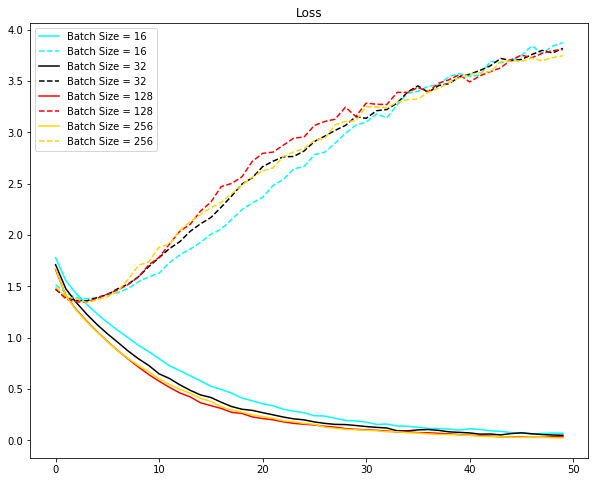

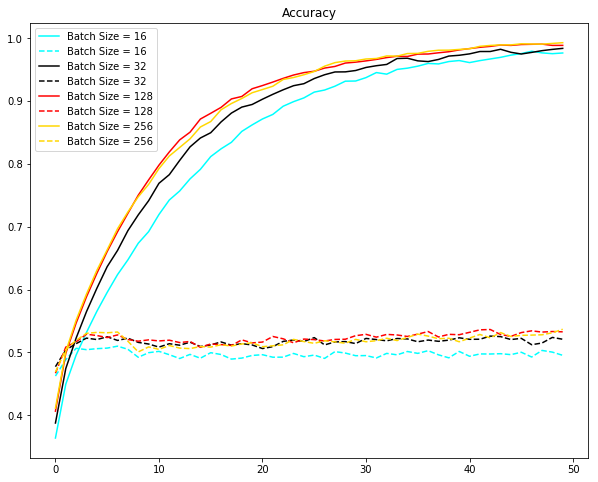

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ['aqua','black','red','gold']

plt.figure(figsize=(10, 8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()